In [1]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
import imageio
import json
import time

from collections import Counter
from matplotlib.pyplot import figure
from matplotlib import animation

from Bio.PDB import *
import nglview as nv
import math
import warnings
from Bio.PDB.StructureBuilder import PDBConstructionWarning
warnings.filterwarnings("ignore", category=PDBConstructionWarning)

# this is dangerous of course but uncomment it when you want to run the code
# warnings.filterwarnings("ignore")

from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment



seg_dir = "C:\Users\Kevin\Documents\TDA\afrl\Segmentations"

In [2]:
def fix_chip_start_stop(df, step_size, chip_size):

    ch=[int(x.split("_")[-1]) for x in df['chip_id']]

    start=[c*step_size for c in ch]
    stop=[chip_size+c*step_size for c in ch]

    df['start']=start
    df['stop']=stop
    
    return df

In [3]:
dataset_25=pandas.read_csv("datasets/protein_all_25_12_no_na.csv")
dataset_10=pandas.read_csv("datasets/protein_all_10_5_no_na.csv")
dataset_5=pandas.read_csv("datasets/protein_all_5_3_no_na.csv")

fix_chip_start_stop(dataset_25,12,25)
fix_chip_start_stop(dataset_10,5,10)
fix_chip_start_stop(dataset_5,3,5)


pdb_list, length_dict, input_features = np.load("datasets/full-input-features.npy",allow_pickle=True)
pdb_list_y, distance_maps_cb = np.load("datasets/full-distance-maps-cb.npy",encoding="latin1",allow_pickle=True)


In [5]:
# functions
def get_rows_from_segmentation(seg):
    with open(seg_dir+seg) as jsonf:
        a=json.load(jsonf)
        df=dataset.iloc[[int(m) for m in a['rowList']],:]
        return df


In [6]:
def ground_truth_window_avg(df):
    aa_length=max(df["stop"])
    mean_ss=[]

    for aa in range(0,aa_length):
        chip=df[(df["start"]<=aa) & (df["stop"]>aa)]
        gt=["ground_truth_"+ss for ss in "HBEGITS"]
        mean_ss.append(chip[gt].mean(0))
#         print(aa)
    gt_avg=pandas.DataFrame(mean_ss)
    
    return gt_avg


In [8]:

def draw_ss_predicts(index,ss):
    
#     H, G and I to H; E to E; the rest to C
    ss_dict={
        "H":0,
        "G":0,
        "I":0,
        "E":1,
        "B":2,
        "T":2,
        "S":2             
            }
    
    aa_length=length_dict[pdb_list[index]]
    
    plt.figure(figsize=(15,10))

    df25=dataset_25[dataset_25["protein_id"]==dataset_25["protein_id"].unique()[index]] 
    df10=dataset_10[dataset_10["protein_id"]==dataset_10["protein_id"].unique()[index]] 
    df5=dataset_5[dataset_5["protein_id"]==dataset_5["protein_id"].unique()[index]] 

    plt.subplot(4,1,1)
    y=ground_truth_window_avg(df5)["ground_truth_"+ss]
    x=range(0,len(y))
    plt.bar(x,y,1)
    plt.xlim((0,aa_length))    

    plt.subplot(4,1,2)
    y=ground_truth_window_avg(df10)["ground_truth_"+ss]
    x=range(0,len(y))
    plt.bar(x,y,1)
    plt.xlim((0,aa_length))

    plt.subplot(4,1,3)
    y=ground_truth_window_avg(df25)["ground_truth_"+ss]
    x=range(0,len(y))
    plt.bar(x,y,1)
    plt.xlim((0,aa_length))

    plt.subplot(4,1,4)
    y=[1-n for n in input_features[pdb_list[index]][ss_dict[ss]].astype(np.float)]
    x=range(0,len(y))
    plt.bar(x,y,1)
    plt.xlim((0,aa_length))


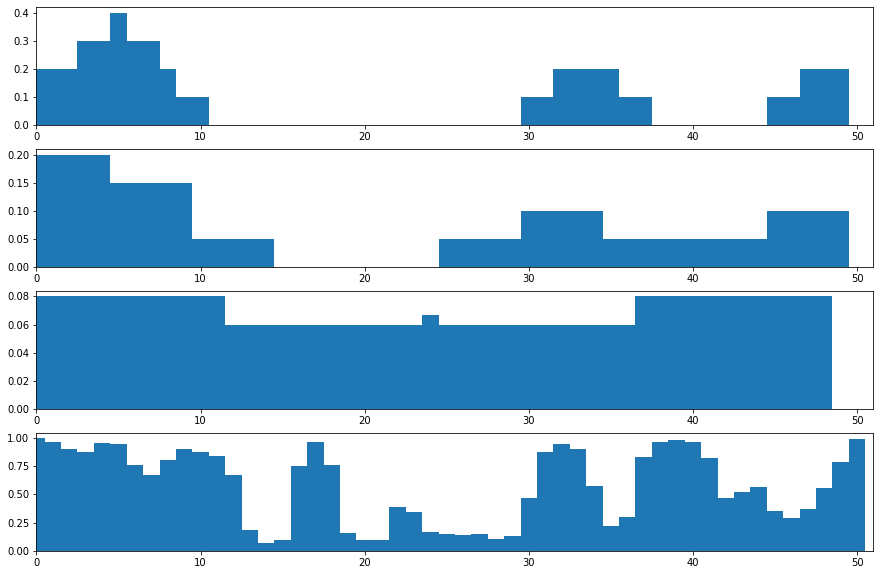

In [71]:
# "HBEGITS"
draw_ss_predicts(25,"B")

In [74]:
dataset_25.loc[0:10]


# def ramachandran_plot(pdb_id, degrees=True):
#     df = get_torsion_angles(pdb_id, degrees)
#     x = df['Phi']
#     y = df['Psi']
#     # Generate plot
#     plt.plot(x, y, ".")
#     plt.title('Ramachandran Plot')
#     if degrees:
#         plt.xlabel(f'$\Phi$ Angle (Degrees)')
#         plt.xlim(-180, 180)
#         plt.ylabel(f'$\Psi$ Angle (Radians)')
#         plt.ylim(-180, 180)
#         plt.show()
#     else:
#         plt.xlabel(f'$\Phi$ Angle (Radians)')
#         plt.xlim(-math.pi, math.pi)
#         plt.ylabel(f'$\Psi$ Angle (Radians)')
#         plt.ylim(-math.pi, math.pi)
#         plt.show()

,Unnamed: 0,Unnamed: 0.1,protein_id,chip_id,start,stop,dist_0,dist_1,dist_2,dist_3,...,solv_access_16,solv_access_17,solv_access_18,solv_access_19,solv_access_20,solv_access_21,solv_access_22,solv_access_23,solv_access_24,ss_majority_categorical
0,0,0,12asA0,chip_0,0,25,2.931498,4.466173,4.830971,5.929355,...,0.076923,0.524194,0.080808,0.018293,0.396907,0.644330,0.463710,0.121951,0.476190,H
1,1,1,12asA0,chip_1,12,37,3.148242,4.942146,5.011508,6.109199,...,0.524194,0.080808,0.018293,0.396907,0.644330,0.463710,0.121951,0.476190,0.024390,None
2,2,2,12asA0,chip_2,24,49,3.400494,6.638870,9.738158,12.659022,...,0.080808,0.018293,0.396907,0.644330,0.463710,0.121951,0.476190,0.024390,0.201183,None
3,3,3,12asA0,chip_3,36,61,3.473039,5.952474,7.897916,8.550533,...,0.018293,0.396907,0.644330,0.463710,0.121951,0.476190,0.024390,0.201183,0.262887,None
4,4,4,12asA0,chip_4,48,73,3.076461,6.190106,9.162886,11.840832,...,0.396907,0.644330,0.463710,0.121951,0.476190,0.024390,0.201183,0.262887,0.014085,None
5,5,5,12asA0,chip_5,60,85,3.465978,6.825651,10.210162,13.602541,...,0.644330,0.463710,0.121951,0.476190,0.024390,0.201183,0.262887,0.014085,0.136364,None
6,6,6,12asA0,chip_6,72,97,3.187567,4.704804,4.751395,5.968911,...,0.463710,0.121951,0.476190,0.024390,0.201183,0.262887,0.014085,0.136364,0.103774,None
7,7,7,12asA0,chip_7,84,109,3.311531,5.471488,9.184711,12.485128,...,0.121951,0.476190,0.024390,0.201183,0.262887,0.014085,0.136364,0.103774,0.110294,None
8,8,8,12asA0,chip_8,96,121,3.268903,4.931504,6.315815,9.363784,...,0.476190,0.024390,0.201183,0.262887,0.014085,0.136364,0.103774,0.110294,0.053254,None
9,9,9,12asA0,chip_9,108,133,3.271093,6.159716,9.532755,13.027534,...,0.024390,0.201183,0.262887,0.014085,0.136364,0.103774,0.110294,0.053254,0.103659,None
